<a href="https://colab.research.google.com/github/PoonamDighe/ALY6110_DATA-MANAGEMENT-AND-BIG-DATA/blob/master/DIGHE_Module4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Insurance.csv to Insurance.csv


In [5]:
dataset = spark.read.csv('Insurance.csv', inferSchema=True, header = True)

In [6]:
dataset.show(5)

+---+------+----+--------+------+---------+--------+
|age|   sex| bmi|children|smoker|   region|expenses|
+---+------+----+--------+------+---------+--------+
| 19|female|27.9|       0|     1|southwest|16884.92|
| 18|  male|33.8|       1|     0|southeast| 1725.55|
| 28|  male|33.0|       3|     0|southeast| 4449.46|
| 33|  male|22.7|       0|     0|northwest|21984.47|
| 32|  male|28.9|       0|     0|northwest| 3866.86|
+---+------+----+--------+------+---------+--------+
only showing top 5 rows



In [7]:
row = dataset.count()
print(row)

1338


In [8]:
dataset.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- expenses: double (nullable = true)



In [9]:
dataset.describe().show()

+-------+------------------+------+------------------+-----------------+-------------------+---------+------------------+
|summary|               age|   sex|               bmi|         children|             smoker|   region|          expenses|
+-------+------------------+------+------------------+-----------------+-------------------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|               1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.665470852017993|  1.0949177877429|0.20478325859491778|     null|13270.422414050803|
| stddev|14.049960379216147|  null|  6.09838219000336|1.205492739781914|0.40369403754561717|     null|12110.011239706473|
|    min|                18|female|              16.0|                0|                  0|northeast|           1121.87|
|    max|                64|  male|              53.1|                5|                  1|southwest|          63770.43|
+-------+---------------

In [10]:
#Vectorization
only_feature = ['age','bmi','children','smoker']

In [11]:
assembler = VectorAssembler(inputCols=only_feature, outputCol = 'feature')

In [12]:
feat_df = assembler.transform(dataset).select('feature')

In [13]:
feat_df.show(5)

+-------------------+
|            feature|
+-------------------+
|[19.0,27.9,0.0,1.0]|
|[18.0,33.8,1.0,0.0]|
|[28.0,33.0,3.0,0.0]|
|[33.0,22.7,0.0,0.0]|
|[32.0,28.9,0.0,0.0]|
+-------------------+
only showing top 5 rows



In [14]:
#Standardize features for principal component analysis
scaler = StandardScaler(
    inputCol = 'feature',
    outputCol = 'scaledFeature',
    withMean = True,
    withStd = True
).fit(feat_df)

In [15]:
df_scaled = scaler.transform(feat_df)
df_scaled.show(6)

+-------------------+--------------------+
|            feature|       scaledFeature|
+-------------------+--------------------+
|[19.0,27.9,0.0,1.0]|[-1.4382265049624...|
|[18.0,33.8,1.0,0.0]|[-1.5094010828978...|
|[28.0,33.0,3.0,0.0]|[-0.7976553035437...|
|[33.0,22.7,0.0,0.0]|[-0.4417824138666...|
|[32.0,28.9,0.0,0.0]|[-0.5129569918020...|
|[31.0,25.7,0.0,0.0]|[-0.5841315697375...|
+-------------------+--------------------+
only showing top 6 rows



In [16]:
#Train model for two principal component analysis

n_components = 2
pca = PCA(
    k = n_components,
    inputCol = 'scaledFeature',
    outputCol = 'pcafeature').fit(df_scaled)

df_pca = pca.transform(df_scaled)
print("Explained Variance ratio", pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance ratio [0.28081393 0.25167095]
+-------------------+--------------------+--------------------+
|            feature|       scaledFeature|          pcafeature|
+-------------------+--------------------+--------------------+
|[19.0,27.9,0.0,1.0]|[-1.4382265049624...|[1.76584887644129...|
|[18.0,33.8,1.0,0.0]|[-1.5094010828978...|[0.69084157358246...|
|[28.0,33.0,3.0,0.0]|[-0.7976553035437...|[-0.2168417424277...|
|[33.0,22.7,0.0,0.0]|[-0.4417824138666...|[1.36997404924438...|
|[32.0,28.9,0.0,0.0]|[-0.5129569918020...|[0.76401552788294...|
|[31.0,25.7,0.0,0.0]|[-0.5841315697375...|[1.15185672501018...|
+-------------------+--------------------+--------------------+
only showing top 6 rows



In [17]:
#Collect distributed data in numpy array and then convert to pandas dataframe
X_pca = df_pca.rdd.map(lambda row: row.pcafeature).collect()
X_pca = np.array(X_pca)

In [18]:
X_pca

array([[ 1.76584888, -1.41089899],
       [ 0.69084157,  0.34613202],
       [-0.21684174, -0.38098497],
       ...,
       [ 0.61159812,  0.73590454],
       [ 1.63654838,  0.77264639],
       [-0.44112795, -1.15521627]])

In [19]:
#Convery Array to DF
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,1.765849,-1.410899
1,0.690842,0.346132
2,-0.216842,-0.380985
3,1.369974,0.851386
4,0.764016,0.835009


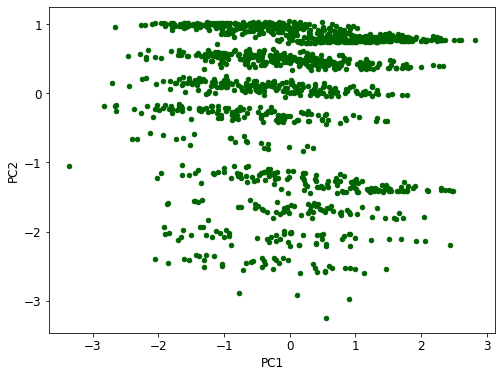

In [22]:
#Plot two principal components
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size'] = 12
ax1 = df_pca.plot.scatter(x='PC1', y='PC2', c='DarkGreen')

In [28]:
#Vectorize features and target together for model development
#Linear Regression
output = assembler.transform(dataset)

#input vs output
finalized_data = output.select('feature','expenses')
finalized_data.show()

+-------------------+--------+
|            feature|expenses|
+-------------------+--------+
|[19.0,27.9,0.0,1.0]|16884.92|
|[18.0,33.8,1.0,0.0]| 1725.55|
|[28.0,33.0,3.0,0.0]| 4449.46|
|[33.0,22.7,0.0,0.0]|21984.47|
|[32.0,28.9,0.0,0.0]| 3866.86|
|[31.0,25.7,0.0,0.0]| 3756.62|
|[46.0,33.4,1.0,0.0]| 8240.59|
|[37.0,27.7,3.0,0.0]| 7281.51|
|[37.0,29.8,2.0,0.0]| 6406.41|
|[60.0,25.8,0.0,0.0]|28923.14|
|[25.0,26.2,0.0,0.0]| 2721.32|
|[62.0,26.3,0.0,1.0]|27808.73|
|[23.0,34.4,0.0,0.0]| 1826.84|
|[56.0,39.8,0.0,0.0]|11090.72|
|[27.0,42.1,0.0,1.0]|39611.76|
|[19.0,24.6,1.0,0.0]| 1837.24|
|[52.0,30.8,1.0,0.0]|10797.34|
|[23.0,23.8,0.0,0.0]| 2395.17|
|[56.0,40.3,0.0,0.0]|10602.39|
|[30.0,35.3,0.0,1.0]|36837.47|
+-------------------+--------+
only showing top 20 rows



In [29]:
#Split dataset into training and testing dataset
train_data, test_data = finalized_data.randomSplit([0.8,0.2]) 

In [30]:
#Fitting Model
regressor = LinearRegression(featuresCol='feature', labelCol='expenses')

regressor = regressor.fit(train_data)

In [31]:
regressor

LinearRegressionModel: uid=LinearRegression_344a7b0f531e, numFeatures=4

In [32]:
#Find out model coefficients and intercept
coeff = regressor.coefficients
intr = regressor.intercept

print("The coef of Model is : %a" %coeff)
print("The Intercept of the model is: %f" %intr)

The coef of Model is : DenseVector([257.6489, 344.4252, 552.1479, 23279.8581])
The Intercept of the model is: -12810.044845


In [33]:
#Evaluate model for test dataset
pred = regressor.evaluate(test_data)

#predict the model
pred.predictions.show()

+-------------------+--------+-------------------+
|            feature|expenses|         prediction|
+-------------------+--------+-------------------+
|[18.0,23.1,0.0,0.0]|  1704.7|-216.14340247221298|
|[18.0,23.2,0.0,0.0]| 1121.87|-181.70088607699108|
|[18.0,26.1,0.0,0.0]| 1708.93|  817.1320893845077|
|[18.0,26.3,0.0,0.0]| 2198.19|  886.0171221749551|
|[18.0,26.7,0.0,0.0]| 1615.77| 1023.7871877558518|
|[18.0,30.1,0.0,0.0]|21344.85| 2194.8327451934692|
|[18.0,32.1,2.0,0.0]| 2801.26|   3987.97894254498|
|[18.0,33.3,0.0,0.0]| 1135.94| 3296.9932698406374|
|[18.0,33.7,0.0,0.0]|  1136.4|  3434.763335421536|
|[18.0,33.9,0.0,0.0]|11482.63| 3503.6483682119815|
|[18.0,37.3,0.0,0.0]| 1141.45|  4674.693925649599|
|[18.0,37.3,1.0,0.0]| 2219.45|  5226.841860373113|
|[18.0,39.2,0.0,0.0]| 1633.04|  5329.101737158855|
|[18.0,40.3,0.0,0.0]| 1634.57|  5707.969417506321|
|[19.0,17.5,0.0,0.0]| 1621.34| -1887.275423115807|
|[19.0,21.8,0.0,0.0]| 1627.28| -406.2472181211724|
|[19.0,24.6,1.0,0.0]| 1837.24| 

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = "expenses", predictionCol = "prediction", metricName = "rmse")

#Root Mean Square Error
rmse = eval.evaluate(pred.predictions)
print("RMSE : %f" %rmse)

#mean square error
mse = eval.evaluate(pred.predictions,{eval.metricName: "mse"})
print("MSE: %.3f" % mse)

#mean absolute error
mae = eval.evaluate(pred.predictions,{eval.metricName: "mae"})
print("MAE: %.3f" % mae)

#r2 - coefficient
r2 = eval.evaluate(pred.predictions,{eval.metricName: "r2"})
print("r2: %.3f" % r2)

RMSE : 5377.889128
MSE: 28921691.475
MAE: 3684.011
r2: 0.798
